In [25]:
import numpy as np

Text(0.5, 1.0, 'Data to be clustered by Kmeans')

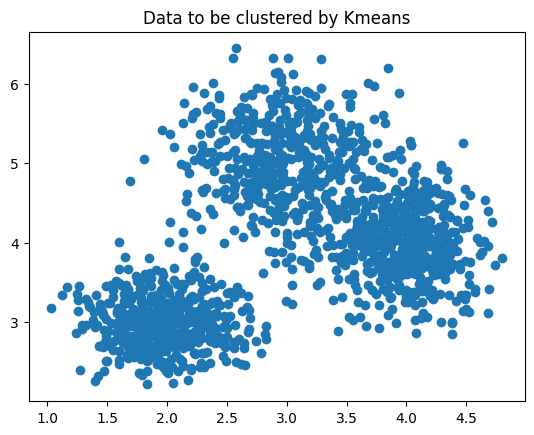

In [26]:
#generate the first cluster
import matplotlib.pyplot as plt

mean=[2,3]
cov_matrix=[[0.1, 0],[0, 0.1]]
n_samples=500

data1=np.random.multivariate_normal(mean,cov_matrix,n_samples)
x1=data1[:,0]
y1=data1[:,1]

#generate the second cluster
mean=[3,5]
cov_matrix=[[0.2, 0],[0, 0.3]]
n_samples=500

data2=np.random.multivariate_normal(mean,cov_matrix,n_samples)
x2=data2[:,0]
y2=data2[:,1]

#generate the third cluster
mean=[4,4]
cov_matrix=[[0.1, 0],[0, 0.2]]
n_samples=500

data3=np.random.multivariate_normal(mean,cov_matrix,n_samples)
x3=data3[:,0]
y3=data3[:,1]

x=np.concatenate((x1, x2, x3))
y=np.concatenate((y1,y2, y3))
points=np.concatenate((data1, data2, data3))

ax=plt.figure

plt.scatter(x,y)
plt.title("Data to be clustered by Kmeans")

In [27]:
#define initial centroids
#you can define them randomly or start from a raw visual guess

cluster_amount=3
centroids=np.zeros((cluster_amount,2))

for i in range(cluster_amount):
  sorted=np.random.randint(x.shape[0])
  centroids[i]=np.array((x[sorted], y[sorted]))


#generating one hot encoders

one_hot_encoders = np.zeros((cluster_amount,cluster_amount))
for i in range(cluster_amount):
  hot_encoder=np.zeros(cluster_amount)
  hot_encoder[i]=1
  one_hot_encoders[i]=hot_encoder

n_int=4
for x in range(n_int):
  euc_distances=np.zeros((points.shape[0], cluster_amount))
  for p in range(points.shape[0]):
    for i in range(centroids.shape[0]):
      euc_distances[p][i]=np.linalg.norm(np.array(points[p]-centroids[i]))

  max_values = np.amax(euc_distances, axis=1)
  max_indices = np.argmax(euc_distances, axis=1)

  cluster_dict={}

  i=0
  for point, index in zip(points, max_indices):
    #new record for every iteration
    cluster_dict[f"point_{i}"] = {
        "coordinates":point,
        "cluster":one_hot_encoders[index]
    }
    i=i+1

  pontuation=np.zeros(cluster_amount)
  centroids=np.zeros((cluster_amount,2))
  for i in range(one_hot_encoders.shape[0]):
    target_cluster=one_hot_encoders[i]
    counter=0
    for record in cluster_dict.values():
      if np.array_equal(record["cluster"],target_cluster):
        centroids[i] += record['coordinates']
        counter=counter+1
    pontuation[i]=counter

  centroids=np.array((centroids.T/pontuation).T) #initial value of centroids for the Soft Kmeans

In [28]:
total=int(np.sum(pontuation))
mixing_coefficients=pontuation/total    #initial value of mixing coefficients for the Soft Kmeans

K-means generally works poorly, it relies on euclidean distance to form circular clusters, but that's not always the case.
bad initialization (random) can lead it to wrong results. This is a bigger downsize for K-means in the case of high-dimensional data
when visualization becames more complicated.
Depending on the initialization or the data generated to be clustered, this algorithm does not work, speccially when the generating souce produces clusters
that are considerably distant from the others.

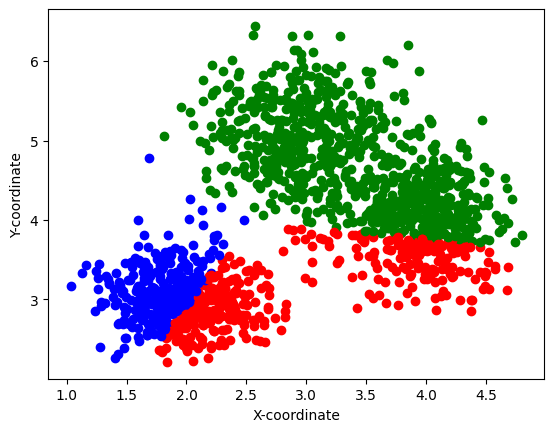

In [29]:
# Extract coordinates and cluster data
data=cluster_dict
coordinates = [point['coordinates'] for point in data.values()]
clusters = [point['cluster'] for point in data.values()]

# Create a scatter plot with different colors for different clusters
colors = ['r', 'g', 'b']  # Red, green, and blue for clusters
for i, cluster in enumerate(clusters):
    plt.scatter(coordinates[i][0], coordinates[i][1], c=colors[np.argmax(cluster)], label=f'point_{i}')

# Add labels and legend
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

# Show the plot
plt.show()

In [30]:
blocks=[]
for i in range((cluster_amount)):
  block=[]
  for point_id, point in cluster_dict.items():
    if np.array_equal(point["cluster"], one_hot_encoders[i]):
      block.append(point["coordinates"])
  blocks.append(block)

cov_matrix=[]
for i in range((cluster_amount)):
  matrix=np.array(blocks[i]-centroids[i]).T@np.array(blocks[i]-centroids[i])/int(pontuation[i])
  cov_matrix.append(matrix)             #initial value of covariance matrixes for the soft Kmeans

In [31]:
data=np.zeros((total,matrix.shape[0]))
i=0
for point_id, point in cluster_dict.items():
  data[i] = point["coordinates"]
  i+=1

In [32]:
def Gaussian(x,centroid, covmatrix):
  inverse = np.linalg.inv(covmatrix)
  det=np.linalg.det(covmatrix)
  argument = np.array(x - centroid).T@inverse@np.array(x - centroid)
  constant=((1/2*np.pi)**(covmatrix.shape[0]/2))*(1/(det**0.5))
  result=constant*np.exp(-0.5*argument)
  return result

In [33]:
def gammakn(x, k, cov_matrix):
  pik = mixing_coefficients[k]
  numerator=pik*Gaussian(x, centroids[k], cov_matrix[k])
  normalization_factor=0
  for j in range(len(mixing_coefficients)):
    normalization_factor += mixing_coefficients[j]*Gaussian(x, centroids[j], cov_matrix[j])
  gammakn=numerator/normalization_factor
  return gammakn


In [34]:
  Nks=np.zeros(cluster_amount)
  for k in range(cluster_amount):
    summation=0
    for n in range(len(data)):
      summation+=gammakn(data[n], k, cov_matrix)
    Nks[k]=summation

In [35]:
def Gaussian(x,centroid, covmatrix):
  inverse = np.linalg.inv(covmatrix)
  det=np.linalg.det(covmatrix)
  argument = np.array(x - centroid).T@inverse@np.array(x - centroid)
  constant=((1/2*np.pi)*(covmatrix.shape[0]/2))*(1/(det**0.5))
  result=constant*np.exp(-0.5*argument)
  return result

def gammakn(n, k):
  pik = mixing_coefficients[k]
  numerator=pik*Gaussian(n, centroids[k], cov_matrix[k])
  normalization_factor=0
  for j in range(len(mixing_coefficients)):
    normalization_factor += mixing_coefficients[j]*Gaussian(n, centroids[j], cov_matrix[j])
  gammakn=numerator/normalization_factor
  return gammakn

Nks=np.zeros(cluster_amount)
for k in range(cluster_amount):
  summation=0
  for n in range(len(data)):
    summation+=gammakn(data[n], k )
  Nks[k]=summation

mixing_coefficients=Nks/total

In [36]:
def soft_k_means_gmm(data, cluster_amount, n_iter=10):
    centroids = data[:cluster_amount]
    cov_matrixes = [np.identity(data.shape[1]) for _ in range(cluster_amount)]
    mixing_coefficients = np.ones(cluster_amount) / cluster_amount

    for iteration in range(n_iter):
        # E-step: Compute posterior probabilities for each data point and each cluster
        posterior_probs = np.zeros((len(data), cluster_amount))

        for n in range(len(data)):
            for k in range(cluster_amount):
                posterior_probs[n][k] = gammakn(data[n], k)

        # Normalize the posterior probabilities
        posterior_probs /= np.sum(posterior_probs, axis=1)[:, np.newaxis]

        # M-step: Update parameters (centroids, covariance matrices, mixing coefficients)
        Nks = np.sum(posterior_probs, axis=0)  # Total responsibility for each cluster

        # Update mixing coefficients
        mixing_coefficients = Nks / len(data)

        # Update centroids
        for k in range(cluster_amount):
            centroids[k] = np.sum(posterior_probs[:, k][:, np.newaxis] * data, axis=0) / Nks[k]

        # Update covariance matrices
        cov_matrixes = []
        for k in range(cluster_amount):
            covma = np.zeros((data.shape[1], data.shape[1]))
            for n in range(len(data)):
                diff = np.array(data[n] - centroids[k])
                covma += (posterior_probs[n][k] / Nks[k]) * np.outer(diff, diff)
            cov_matrixes.append(covma)

    return mixing_coefficients, centroids, cov_matrixes, posterior_probs

# Usage
n_iter = 50  # Increase the number of iterations
mixing_coefficients, centroids, cov_matrixes, posterior_probs = soft_k_means_gmm(data, cluster_amount, n_iter)


In [37]:
# After running the algorithm for more iterations, you can use the resulting parameters to update your clusters
# For each data point, calculate the probabilities of belonging to each cluster and assign it to the cluster with the highest probability
final_cluster_assignments = np.argmax(posterior_probs, axis=1)

# Update your cluster_dict based on final_cluster_assignments
for i, (point_id, point_info) in enumerate(cluster_dict.items()):
    point_info['cluster'] = one_hot_encoders[final_cluster_assignments[i]]

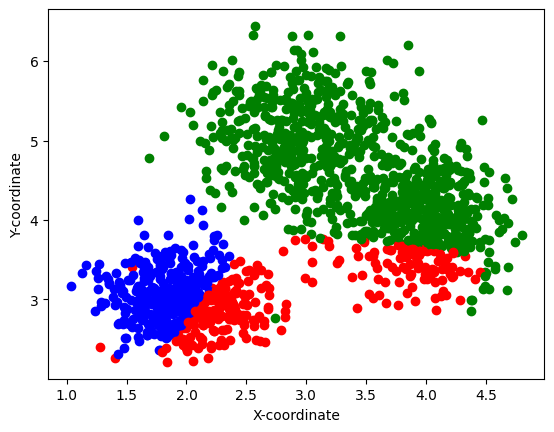

In [38]:
# Extract coordinates and cluster data
data=cluster_dict
coordinates = [point['coordinates'] for point in data.values()]
clusters = [point['cluster'] for point in data.values()]

# Create a scatter plot with different colors for different clusters
colors = ['r', 'g', 'b']  # Red, green, and blue for clusters
for i, cluster in enumerate(clusters):
    plt.scatter(coordinates[i][0], coordinates[i][1], c=colors[np.argmax(cluster)], label=f'point_{i}')

# Add labels and legend
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

# Show the plot
plt.show()